In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/transcriptions.zip"

Archive:  /content/drive/MyDrive/transcriptions.zip
  inflating: 1.txt                   
  inflating: 2.txt                   
  inflating: 3.txt                   
  inflating: 4.txt                   


In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


In [6]:
!pip install pyLDAvis
!pip install sentence_transformers
!python -m spacy download en_core_web_sm



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=9adcf623ecd1ceba0fd6e83fe06fed2fc5a5ae2de000d597a70732050e08a2e6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
2023-05-22 19:23:17.489819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available

In [2]:
import numpy as np
import pandas as pd
import spacy
from gensim import corpora, models
from itertools import islice,chain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def load_text(path):
	"""
	Loads the text content from a file.

	Args:
			path (str): The path to the file.

	Returns:
			str: The text content of the file.
	"""
	with open(path) as f:
		texts = f.read()
	return texts

In [6]:
texts=load_text("/content/1.txt") #load input txt file

In [7]:
print(texts)

Good afternoon. We're gonna spend the next 1000 200 seconds talking about way too many things, in fact, but principally we're going to talk about one thing, which is you. I am I the user interface and the foundational assertion for this talk and for our work at Oblong Industries. Is that really?
For the last 30 years, we have spent an increasingly small and vanishing amount of effort and time and attention on what might be the single most important aspect of computation, the user interface and as a kind of contextual flavoring agent, I want to view that through the lens of professional work. We're all in this audience engaged in professional work or interested in work. That itself is characterized by being more complex than an app. Eso. Let's take a little swing through logic town here just to sort of set the stage.
So we all have professional task. We have work life and we have domestic life. Let's talk about work life. The world is not getting simpler. Our work that work flows, the w

In [7]:
nlp = spacy.load('en_core_web_sm') #load spacy english language model

In [8]:
def get_sentences(texts):
  """
  Segments the given text into sentences.

  Args:
      texts (str): The input text.

  Returns:
      sents (list): A list of segmented sentences.
  """
  sents = []
  doc = nlp(texts)
  for sent in doc.sents:
    sents.append(sent)
  return sents



In [9]:
sents=get_sentences(texts)

In [11]:
print(f"After Sentence Segmentation, the sixth sentence is :    {sents[5]}" )

After Sentence Segmentation, the sixth sentence is :    We're all in this audience engaged in professional work or interested in work.


In [10]:
def tokenize_sentences(sents,min_length=3):
  """
  Tokenizes the sentences by applying specific criteria.

  Args:
      sents (list): A list of sentences.
      min_length (int): The minimum length of a token to be included. Defaults to 3.

  Returns:
      tokenized_sents (list): A list of tokenized sentences.
  """
  MIN_LENGTH = min_length
  tokenized_sents = [[token.lemma_.lower() for token in sent 
                      if not token.is_stop and 
                      not token.is_punct and token.text.strip() and 
                      len(token) >= MIN_LENGTH] 
                    for sent in sents]
  return tokenized_sents


In [11]:
tokenized_sents=tokenize_sentences(sents,3)

In [12]:
print(f"The sixth sentence after preprocessing and tokenization is : {tokenized_sents[5]}")

The sixth sentence after preprocessing and tokenization is : ['audience', 'engage', 'professional', 'work', 'interested', 'work']


In [13]:
def plot_frequent(sents,n=30,tokenized=False):
  """
  Plots the most frequent tokens in the sentences.

  Args:
      sents (list): A list of sentences.
      n (int): The number of most frequent tokens to plot. Defaults to 30.
      tokenized (bool): Indicates whether the sentences are already tokenized. Defaults to False.

  Returns:
      None
  """

  # Tokenize the sentences and flatten them into a list of tokens
  if not tokenized:
    all_tokens = [token for sentence in sents for token in sentence.text.split()]
  else:
    all_tokens = [token for sentence in tokenized_sents for token in sentence]


  # Count the occurrences of each token
  token_counts = Counter(all_tokens)

  # Get the most frequent tokens and their corresponding counts
  most_common_tokens = token_counts.most_common(n)
  tokens, counts = zip(*most_common_tokens)
  tokens = list(tokens)
  counts = list(counts)
  plt.figure(figsize=(10, 6))
  sns.barplot(x=tokens, y=counts,palette = 'winter')
  plt.xticks(rotation=45)
  plt.xlabel('Tokens')
  plt.ylabel('Counts')
  plt.title('Most Frequent Tokens')
  plt.tight_layout()
  plt.show()




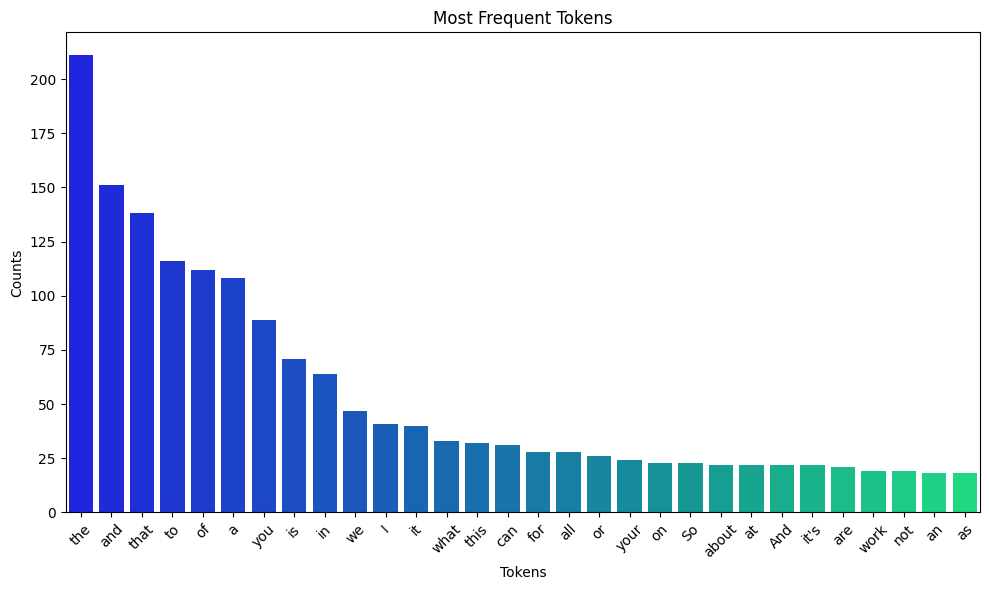

In [14]:
plot_frequent(sents,30,False) # BEFORE PREPROCESSING

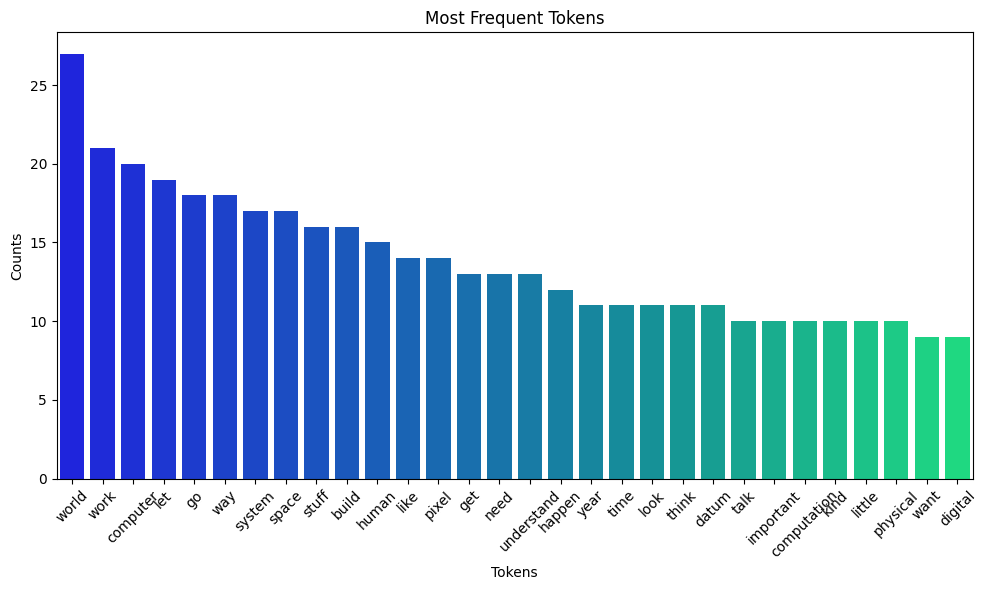

In [15]:
plot_frequent(tokenized_sents,30,True) # AFTER PREPROCESSING

In [16]:
def wordcloud_frequent(tokenized_sents):
  """
  Generates and displays a word cloud based on the most frequent tokens in the tokenized sentences.

  Args:
      tokenized_sents (list): A list of tokenized sentences.

  Returns:
      None
  """

  review_words = ' '.join([word for sent in tokenized_sents for word in sent])
  # Generate the word cloud
  wordcloud = WordCloud(background_color="white",
                        max_words=200,
                        contour_width=8,
                        contour_color="steelblue",
                        collocations=True).generate(review_words)

  # Visualize the word cloud
  fig = plt.figure(1, figsize=(10, 10))
  plt.axis('off')
  plt.imshow(wordcloud)
  plt.show()



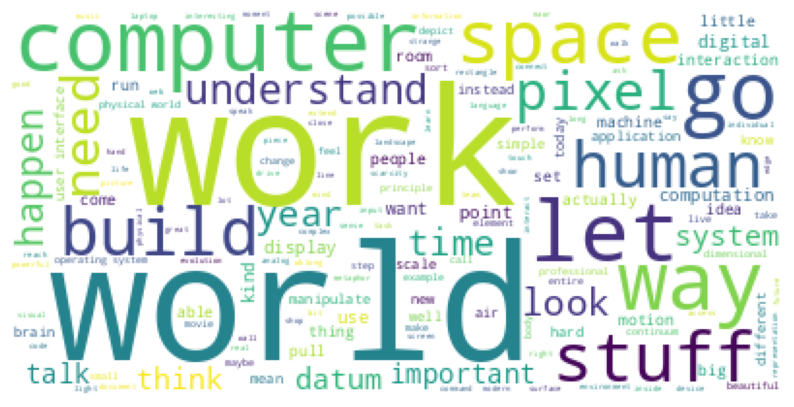

In [19]:
wordcloud_frequent(tokenized_sents) # Most Frequent tokenized words

In [20]:
def bag_of_words(tokenized_sents):
  """
  Creates a bag of words representation of the tokenized sentences, in addition to a dictionary.

  Args:
      tokenized_sents (list): A list of tokenized sentences.

  Returns:
      tuple: A tuple containing the dictionary and bag of words representation.
          - dictionary (gensim.corpora.Dictionary): The dictionary mapping tokens to their IDs.
          - bow (list of list of tuple): The bag of words representation of the tokenized sentences, where each element is a list
            of (token_id, frequency) tuples for each token in the corresponding sentence.
  """
  dictionary = corpora.Dictionary(tokenized_sents)
  bow = [dictionary.doc2bow(sent) for sent in tokenized_sents] # bag of words (id,frequency)
  return dictionary,bow


In [21]:
dictionary,bow=bag_of_words(tokenized_sents)

In [22]:
print(f"Bag Of Words of sixth sentence, written in format (token_id,frequency) : {bow[5]}")

Bag Of Words of sixth sentence, written in format (token_id,frequency) : [(18, 2), (30, 1), (38, 1), (39, 1), (40, 1)]


In [23]:
def optimum_n_topics(bow,dictionary,tokenized_sents):
  """
  Determine the optimum number of topics for LDA model using coherence score.

  Args:
      bow (list of list of tuple): Bag of words representation of the tokenized sentences.
      dictionary (gensim.corpora.Dictionary): The dictionary mapping tokens to their IDs.
      tokenized_sents (list): A list of tokenized sentences.

  Returns:
      int: The optimum number of topics based on the highest coherence score.

  """

  number_of_topics = []
  coherence_score = []

  for i in range(1, 10):
      lda_model =  models.LdaModel(corpus=bow,id2word=dictionary, iterations=50,num_topics=i)
      
      coherence_model_lda = models.CoherenceModel(model=lda_model,
                                          texts=tokenized_sents,
                                          dictionary=dictionary,
                                          coherence='c_v')
      
      coherence_lda = coherence_model_lda.get_coherence()
      number_of_topics.append(i)
      coherence_score.append(coherence_lda)
      print(coherence_lda)
      
  # Print a line plot
  plt.plot(number_of_topics, coherence_score)
  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.title('Coherence Score by Number of Topics')
  plt.show()

  return 1+np.argmax(coherence_score)


0.29917089137472297


0.39225336919572684


0.44873964530433047


0.45050242035178384


0.47481478329573434


0.4431427842649828


0.46774785070982894


0.49150364324340734
0.5000215605971995


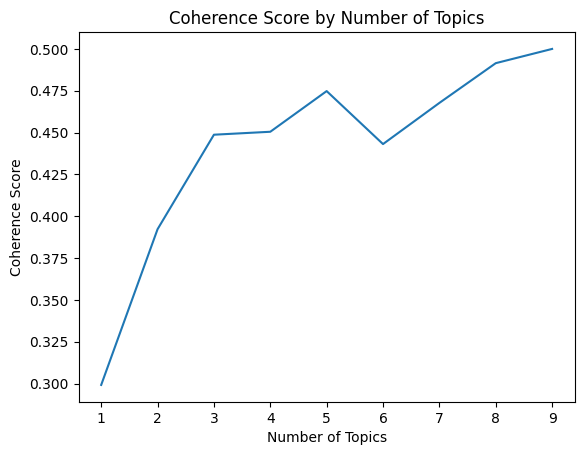

In [25]:
num_topics=optimum_n_topics(bow,dictionary,tokenized_sents)

In [26]:
num_topics = 5 # Approximately since there is no big difference

In [27]:
def lda_model(dictionary,bow,num_topics=7,num_passes=1000):
  """
  Trains an LDA (Latent Dirichlet Allocation) topic model on the given bag-of-words representation.

  Args:
      dictionary (gensim.corpora.Dictionary): The dictionary mapping tokens to their IDs.
      bow (list of list of tuple): The bag-of-words representation of the corpus.
      num_topics (int, optional): The number of topics to be generated. Defaults to 7.
      num_passes (int, optional): The number of passes through the corpus during training. Defaults to 1000.

  Returns:
      gensim.models.ldamodel.LdaModel: The trained LDA topic model.
  """
  N_TOPICS = num_topics
  N_PASSES = num_passes
  topic_model = models.LdaModel(corpus=bow, id2word=dictionary, 
                                num_topics=N_TOPICS, passes=N_PASSES)
  return topic_model



In [28]:
num_passes=1000
topic_model=lda_model(dictionary,bow,num_topics,num_passes)

In [35]:
def topics_analysis(topic_model,bow,dictionary):
  """
  Generate an interactive visualization to analyze the topics discovered by the LDA model.

  Args:
      topic_model (gensim.models.LdaModel): Trained LDA topic model.
      bow (list of list of tuple): Bag-of-words representation of the corpus.
      dictionary (gensim.corpora.Dictionary): Dictionary mapping words to their IDs.

  Returns:
      None
  """

  pyLDAvis.enable_notebook()

  vis = pyLDAvis.gensim_models.prepare(topic_model, 
                                      bow, 
                                      dictionary=dictionary)
  return vis


In [40]:
vis=topics_analysis(topic_model,bow,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.095314  0.033166       1        1  24.768389
4     -0.152545  0.025478       2        1  24.141165
3      0.006321 -0.150098       3        1  19.710685
2      0.005588  0.062182       4        1  18.107617
0      0.045322  0.029273       5        1  13.272144, topic_info=       Term       Freq      Total Category  logprob  loglift
58    world  20.000000  20.000000  Default  30.0000  30.0000
158  happen   8.000000   8.000000  Default  29.0000  29.0000
18     work  15.000000  15.000000  Default  28.0000  28.0000
11      way  13.000000  13.000000  Default  27.0000  27.0000
217    step   6.000000   6.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
118    pull   1.396653   5.615498   Topic5  -5.0988   0.6281
10    thing   1.397239   6.301466   Topic5  -5.0984   0.5132
97    point   1.397518   6.909992   Topic5  -5.0982   0.4212
250  inside   1.056867   3.427212   Topic5  -5.3776   0.8431
103   build   1.389569  12.007590   Topic5  -5.1039  -0.1370

[295 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
492       4  0.724423        130
222       3  0.720934       1994
622       3  0.721380       21st
503       5  0.752712   absolute
159       5  0.509520  abundance
...     ...       ...        ...
37        1  0.239943       year
37        3  0.479886       year
37        4  0.239943       year
37        5  0.119971       year
343       3  0.961644        yes

[423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [41]:
topic_model.show_topics() # Topics models generated by LDA model and words distribution


[(0,
  '0.017*"computer" + 0.014*"well" + 0.012*"little" + 0.012*"new" + 0.012*"strange" + 0.011*"human" + 0.009*"need" + 0.009*"scarcity" + 0.006*"mean" + 0.006*"movie"'),
 (1,
  '0.024*"let" + 0.019*"way" + 0.016*"build" + 0.014*"human" + 0.014*"talk" + 0.011*"system" + 0.011*"go" + 0.009*"world" + 0.009*"big" + 0.007*"little"'),
 (2,
  '0.022*"happen" + 0.014*"interaction" + 0.014*"way" + 0.011*"continuum" + 0.009*"interface" + 0.009*"pixel" + 0.009*"surface" + 0.009*"come" + 0.009*"think" + 0.009*"need"'),
 (3,
  '0.025*"work" + 0.015*"go" + 0.015*"step" + 0.014*"system" + 0.014*"computer" + 0.013*"think" + 0.013*"stuff" + 0.011*"year" + 0.011*"get" + 0.011*"build"'),
 (4,
  '0.033*"world" + 0.018*"understand" + 0.016*"like" + 0.014*"datum" + 0.014*"digital" + 0.014*"space" + 0.014*"physical" + 0.013*"get" + 0.012*"look" + 0.011*"work"')]

In [42]:
def doctopic_filter(topic_model,bow,num_topics=3,threshold=0.05):
  """
  Filter the document-topic distribution to keep only the top-k topics for each document.

  Args:
      topic_model (gensim.models.LdaModel): Trained LDA topic model.
      bow (list of list of tuple): Bag-of-words representation of the corpus.
      num_topics (int): Number of top topics to keep for each document (default: 3).
      threshold (float): Minimum probability threshold to consider a topic for a document (default: 0.05).

  Returns:
      tuple: A tuple containing the document-topic distribution and the filtered top-k topics.
          - doc_topics (list of list of tuple): Document-topic distribution for each document.
          - top_k_topics (list of list of int): Filtered top-k topics for each document.
  """

  THRESHOLD = threshold
  k = num_topics
  doc_topics = list(topic_model.get_document_topics(bow, minimum_probability=THRESHOLD)) #gets the documents topic distribution
  top_k_topics = [[t[0] for t in sorted(sent_topics, key=lambda x: x[1], reverse=True)][:k] 
                  for sent_topics in doc_topics]
  return doc_topics,top_k_topics

In [43]:
doc_topics,top_k_topics=doctopic_filter(topic_model,bow)

In [44]:
print (f" Topic Distribution in 21th document is : {doc_topics[20]}")

 Topic Distribution in 21th document is : [(0, 0.5935183), (1, 0.10146551), (2, 0.10148744), (3, 0.10352601), (4, 0.10000277)]


In [45]:
print (f" Topic Distribution in seventh document after filteration: {top_k_topics[20]}")

 Topic Distribution in seventh document after filteration: [0, 3, 2]


In [47]:
def topics_scatter(doc_topics,top_k_topics):
  """
  Create a scatter plot of the top topics for each document.

  Args:
      doc_topics (list of list of tuple): Document-topic distribution for each document.
      top_k_topics (list of list of int): Filtered top-k topics for each document.

  Returns:
      None
  """

  # Extract x and y coordinates from top_k_topics
  x_coords = range(len(doc_topics))
  y_coords = [topics[0] for topics in top_k_topics]

  # Create scatter plot
  plt.scatter(x_coords, y_coords)

  # Set labels and title
  plt.xlabel("Document Index")
  plt.ylabel("Number of Top Topics")
  plt.title("Scatter Plot of Top Topics for Documents")

  # Show the plot
  plt.show()


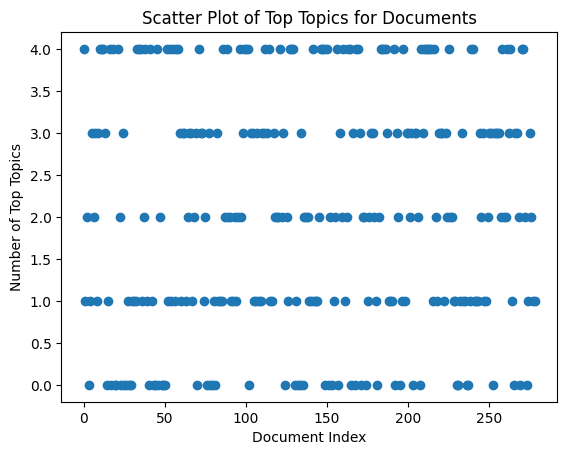

In [48]:
topics_scatter(doc_topics,top_k_topics)

In [49]:
def window(seq, window_size=3):
    """
    Generate a sliding window over a sequence.

    Args:
        seq (iterable): Input sequence.
        window_size (int): Size of the sliding window. Default is 3.

    Yields:
        tuple: A sliding window of size window_size over the sequence.

    """
    WINDOW_SIZE=window_size
    it = iter(seq)
    result = tuple(islice(it, WINDOW_SIZE))
    if len(result) == WINDOW_SIZE: 
        yield result
    for elem in it:
        result = result[1:] + (elem,) # return a sliding window over each 3 consecutive docs in top_k_topics
        yield result

In [50]:
window_size=3
window_topics = window(top_k_topics,window_size)
window_topics = [list(set(chain.from_iterable(window))) 
                for window in window_topics] # concatenate the unique topic ids in each window in a list

In [51]:
print(f"top topics in second document : {top_k_topics[1]} , top topics in third document : { top_k_topics[2]} , top topics in fourth document : {top_k_topics[3]}")
print(f"top topics in their window : {window_topics[1]}") # shifted window group every 3 consecutive documents and concatenate unique topics ids

top topics in second document : [1] , top topics in third document : [2] , top topics in fourth document : [0, 1, 2]
top topics in their window : [0, 1, 2]


In [52]:
binarizer = MultiLabelBinarizer(classes=range(num_topics))
encoded_topic = binarizer.fit_transform(window_topics) # binarize the window for cosine similarity calculation.

In [53]:
print(f" the window after binarization : {encoded_topic[1]}")

 the window after binarization : [1 1 1 0 0]


In [54]:
coherence_scores = [cosine_similarity([pair[0]], [pair[1]])[0][0] 
                for pair in zip(encoded_topic, encoded_topic[1:])] # each two consecutive pairs of sliding windows 


In [55]:
def plot_coherence(coherence_scores):
  """
  Plot coherence scores.

  Args:
      coherence_scores (list): List of coherence scores.

  Returns:
      None

  """
  # Create x-axis values
  x = range(1, len(coherence_scores) + 1)

  # Create line plot
  plt.plot(x, coherence_scores)

  # Set labels and title
  plt.xlabel("Topic Pair")
  plt.ylabel("Cosine Similarity")
  plt.title("Coherence Scores")

  # Show the plot
  plt.show()
  


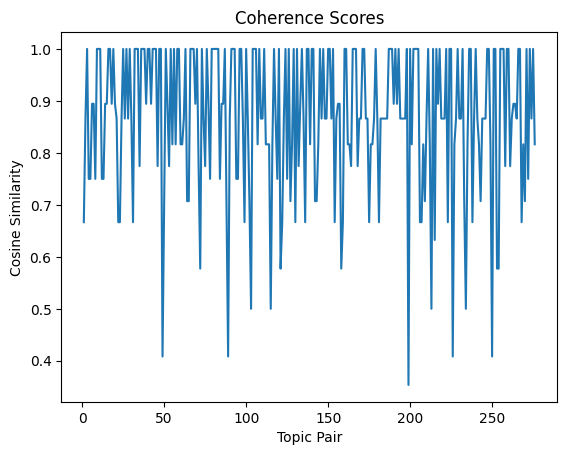

In [56]:
plot_coherence(coherence_scores)

In [57]:
def climb(seq, i, mode='left'): 
    """
    Climb up the sequence to find the maximum peak in the specified direction.

    Args:
        seq (list): The sequence of values.
        i (int): The index to start climbing from.
        mode (str, optional): The direction to climb. Can be 'left' or 'right'. Defaults to 'left'.

    Returns:
        int: The maximum peak value found.

    """
    if mode == 'left':
      # traverse left to search for the maximum left peak 
        while True:
            curr = seq[i]
            if i == 0:
                return curr
            i = i-1
            if not seq[i] > curr:
                return curr
    if mode == 'right': 
     # traverse right to search for maximum right peak
        while True:
            curr = seq[i]
            if i == (len(seq)-1):
                return curr
            i = i+1
            if not seq[i] > curr:
                return curr

In [58]:
def get_depths(scores): 
    """
    Calculate the depth scores using the TextTiling algorithm.

    Args:
        scores (list): The coherence scores between consecutive pairs.

    Returns:
        numpy.ndarray: An array containing the depth scores.

    """
    depths = []
    for i in range(len(scores)): # calculate depth score as TextTiling algorithm
        score = scores[i]
        l_peak = climb(scores, i, mode='left')
        r_peak = climb(scores, i, mode='right')
        depth = 0.5 * (l_peak + r_peak - (2*score))
        depths.append(depth)
    return np.array(depths)


In [59]:
depth_scores = get_depths(coherence_scores)


In [60]:
def plot_coherent_depth(coherence_scores,depth_scores):
  """
  Plot the coherence scores and depth scores together.

  Args:
      coherence_scores (list): The coherence scores for each topic pair.
      depth_scores (list): The depth scores for each topic pair.

  Returns:
      None

  """

  # Create x-axis values
  x = range(len(coherence_scores))

  # Create line plot for coherence scores
  plt.plot(x, coherence_scores, label='Coherence Scores')

  # Create line plot for depth scores
  plt.plot(x, depth_scores, label='Depth Scores')

  # Set labels and title
  plt.xlabel("Topic Pair")
  plt.ylabel("Scores")
  plt.title("Coherence Scores and Depth Scores")

  # Add legend
  plt.legend(fontsize='x-small')

  # Show the plot
  plt.show()



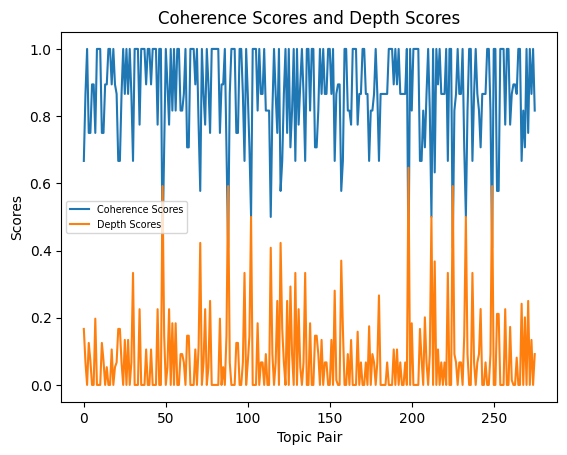

In [61]:
plot_coherent_depth(coherence_scores,depth_scores)

In [62]:
def get_local_maxima(depth_scores, order=1):
    """
    Filter the depth scores by taking local maximum.

    Args:
        depth_scores (list or numpy array): The depth scores.
        order (int, optional): The order of the local maximum filter. Defaults to 1.

    Returns:
        filtered_scores(numpy.ndarray): The filtered depth scores.

    """
    # Find the indices of the local maxima
    maxima_ids = argrelmax(depth_scores, order=order)[0]

    # Create an array of zeros with the same length as depth_scores
    filtered_scores = np.zeros(len(depth_scores))

    # Assign the depth scores to the filtered scores array at the positions of the local maxima
    filtered_scores[maxima_ids] = depth_scores[maxima_ids]

    return filtered_scores


In [63]:
filtered_scores = get_local_maxima(depth_scores, order=1)


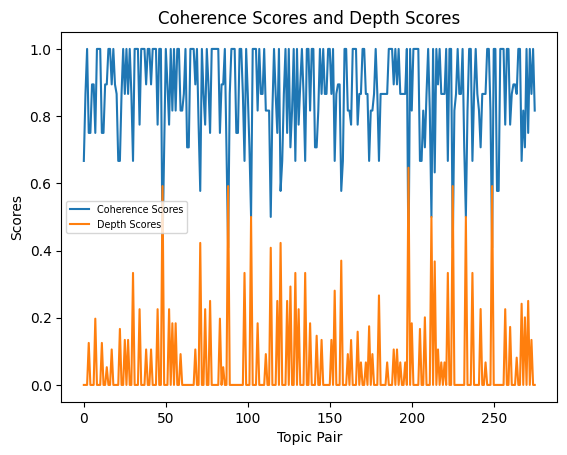

In [64]:
plot_coherent_depth(coherence_scores,filtered_scores)

In [65]:
def compute_threshold(scores):
    """
    Compute the threshold for segmentation based on the scores.

    Args:
        scores (list or numpy array): The scores used for segmentation.

    Returns:
        threshold (float): The computed threshold.

    """
    # Remove zero values from the scores
    s = scores[np.nonzero(scores)]

    # Compute the threshold as the mean minus half the standard deviation
    threshold = np.mean(s) - (np.std(s) / 2)

    return threshold


In [66]:
threshold = 2*compute_threshold(filtered_scores)


In [69]:
def get_threshold_segments(scores, threshold=0.1):
    """
    Get the segment indices where the scores are above the given threshold.

    Args:
        scores (list or numpy array): The scores used for segmentation.
        threshold (float): The threshold value. Default is 0.1.

    Returns:
        segment_ids(numpy.ndarray): The indices of the segments where the scores are above the threshold\
         which are elements with highest topic shift.

    """
    # Find the indices where scores are above the threshold
    segment_ids = np.where(scores >= threshold)[0]

    return segment_ids


In [70]:
segment_ids = get_threshold_segments(filtered_scores, threshold) # elements with highest topic shift 


In [71]:
def plot_threshold_segments(score, threshold, segment_ids):
    """
    Plot the scores with the threshold and selected segments.

    Args:
        scores (list or numpy array): The scores to plot.
        threshold (float): The threshold value.
        segment_ids (list or numpy array): The indices of the selected segments.

    Returns:
        None

    """
    plt.figure(figsize=(10, 6))
    plt.plot(score, color='blue', label='Scores')
    plt.axhline(threshold, color='green', linestyle='-', label='Threshold')
    plt.scatter(segment_ids, score[segment_ids], color='red', label='Selected Segments')
    plt.xlabel('Segment Index')
    plt.ylabel('Depth Scores')
    plt.title('Scores with Threshold and Selected Segments')
    plt.legend()
    plt.show()


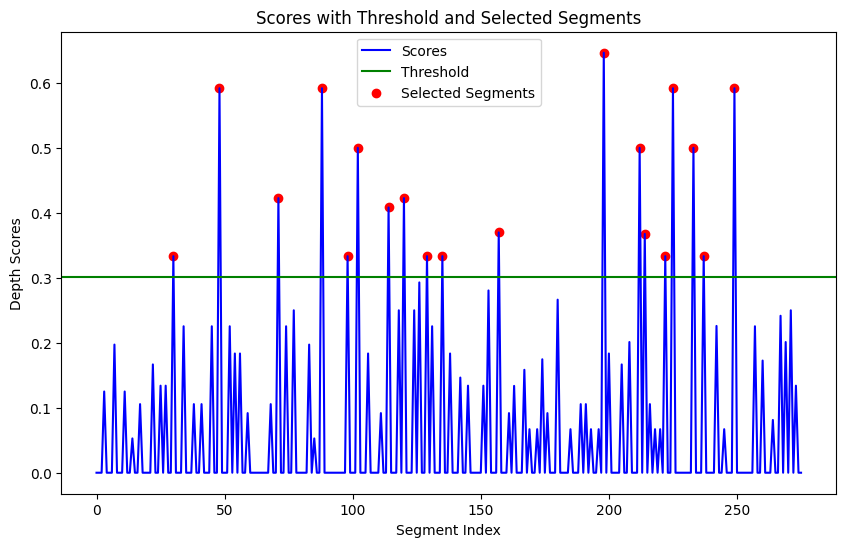

In [72]:
plot_threshold_segments(filtered_scores,threshold,segment_ids)

In [73]:
def segment(segment_ids, window_size, sents):
    """
    Segment the sentences based on the segment indices.

    Args:
        segment_ids (list or numpy array): The indices of the segments.
        window_size (int): The window size used to calculate segment indices.
        sents (list): The list of sentences.

    Returns:
        segmented (list): The segmented sentences.

    """
    segment_indices = segment_ids + window_size  # Correct indices to original document
    segment_indices = [0] + segment_indices.tolist() + [len(sents)]  # Add start and end index
    slices = list(zip(segment_indices[:-1], segment_indices[1:]))  # Slice the topic into the segments
    segmented = [sents[s[0]: s[1]] for s in slices]
    return segmented


In [74]:
segmented=segment(segment_ids,window_size,sents)

In [75]:
print(f" Number Of Segments : {len(segmented)}")

 Number Of Segments : 20


In [76]:
def generate_txt(segmented, output_name='output.txt'):
    """
    Generate a text file with the segmented sentences.

    Args:
        segmented (list): The segmented sentences.
        output_name (str): The name of the output file. Default is 'output.txt'.

    """
    output_file = output_name  # Specify the output file path
    # Open the file in write mode
    with open(output_file, 'w') as file:
        # Write each segment to a new line in the file
        for segment in segmented:
            segment_text = ' '.join([sentence.text for sentence in segment])  # Convert Span objects to strings
            file.write(segment_text + '\n' + "<SEGMENT>" + '\n')  # Write the segment to the file, followed by a newline character


In [77]:
generate_txt(segmented)

In [78]:
MODEL_STR = "sentence-transformers/all-MiniLM-L6-v2" #load the pre-trained BERT model
model = SentenceTransformer(MODEL_STR)


In [80]:
WINDOW_SIZE = 3
window_sent = list(window(sents, WINDOW_SIZE))
window_sent = [' '.join([sent.text for sent in window]) for window in window_sent] # create sliding window on sentences


In [81]:
print(f"first sentence :  {sents[0]} \n")
print(f"second sentence :  {sents[1]} \n")
print(f"third sentence :  {sents[2]} \n")

first sentence :  Good afternoon. 

second sentence :  We're gonna spend the next 1000 200 seconds talking about way too many things, in fact, but principally we're going to talk about one thing, which is you. 

third sentence :  I am I the user interface and the foundational assertion for this talk and for our work at Oblong Industries. 



In [82]:
print(f" window on first three sentences :  {window_sent[0]}") # window of the first 3 sentences

 window on first three sentences :  Good afternoon. We're gonna spend the next 1000 200 seconds talking about way too many things, in fact, but principally we're going to talk about one thing, which is you. I am I the user interface and the foundational assertion for this talk and for our work at Oblong Industries.


In [83]:
encoded_sent = model.encode(window_sent) # encode the sentences in the window with BERT


In [84]:
print(f"encoded window dimensions :  {len(encoded_sent[0])}")

encoded window dimensions :  384


In [85]:
print(f"encoded window :  {encoded_sent[0]}") # encodings of the first 3 sentences

encoded window :  [-5.57596236e-02 -3.37855145e-02  6.28270730e-02 -4.25322130e-02
  9.02353823e-02 -6.01978078e-02  1.34914607e-01  1.26469182e-02
 -3.18834558e-02 -2.48678531e-02 -1.20413326e-01  3.05906665e-02
 -1.89975593e-02 -1.60875637e-03  3.98856066e-02 -5.01925536e-02
  6.47306219e-02 -7.93955326e-02 -8.07916448e-02  5.41777164e-02
  4.45655063e-02  2.59524267e-02 -1.73870306e-02  4.09861505e-02
 -8.47128108e-02  5.39447367e-02  1.75644346e-02 -4.14279625e-02
  1.79539584e-02 -5.04339226e-02 -8.25820044e-02  6.96867555e-02
  4.03334685e-02  3.35679483e-03  1.17385313e-02  3.16325389e-02
  1.34360446e-02 -6.03905581e-02  4.21093218e-02 -7.46233761e-02
  4.49646525e-02 -2.39774399e-02 -2.93680094e-02  3.83372754e-02
  6.24450855e-02 -6.81584403e-02 -2.95169558e-03 -6.05289824e-02
 -7.32006831e-03  1.47647401e-02 -6.50084168e-02  1.87023804e-02
  3.16680185e-02  1.26504311e-02  2.60978490e-02  6.50187209e-03
  4.10792558e-03 -5.15656127e-03 -1.44448662e-02  4.54254039e-02
  3.396

In [86]:
coherence_scores_bert = [cosine_similarity([pair[0]], [pair[1]])[0][0] for pair in zip(encoded_sent, encoded_sent[1:])]


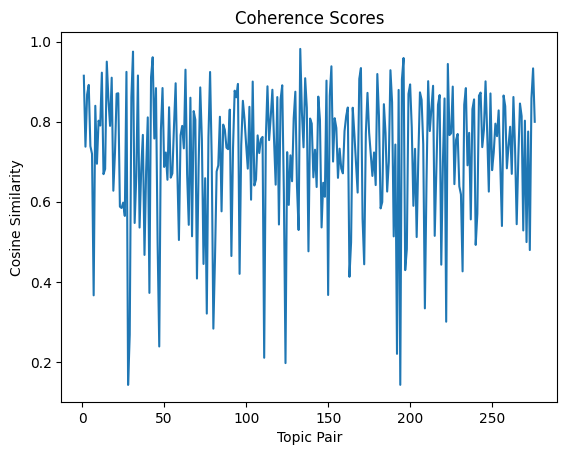

In [87]:
plot_coherence(coherence_scores_bert)

In [88]:
depth_scores_bert = get_depths(coherence_scores_bert)


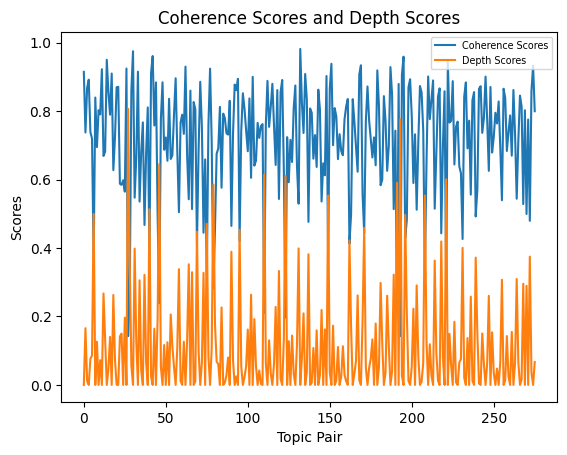

In [89]:
plot_coherent_depth(coherence_scores_bert,depth_scores_bert)

In [91]:
filtered_scores_bert = get_local_maxima(depth_scores_bert , order=1)


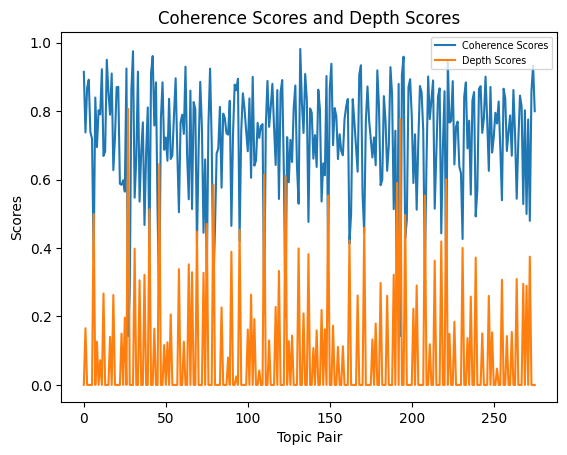

In [92]:
plot_coherent_depth(coherence_scores_bert,filtered_scores_bert)

In [94]:
threshold_bert = 2*compute_threshold(filtered_scores_bert)
print(f"Threshold = {threshold}")
segment_ids_bert = get_threshold_segments(filtered_scores_bert, threshold_bert)


Threshold = 0.3011758964554805


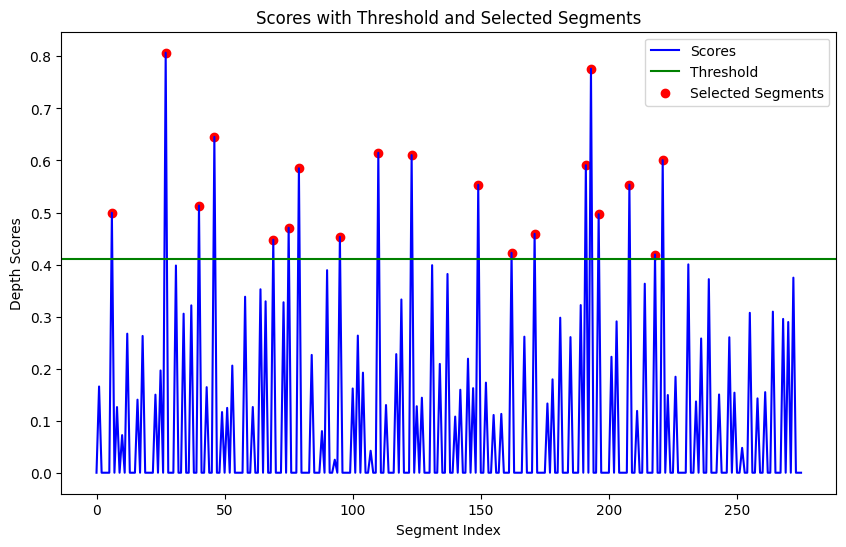

In [95]:
plot_threshold_segments(filtered_scores_bert,threshold_bert,segment_ids_bert)

In [96]:
segments=segment(segment_ids_bert,window_size,sents)


In [98]:
print(f" Number Of Segments : {len(segments)}")

 Number Of Segments : 20


In [97]:
generate_txt(segments,output_name='BERT_Segmentation.txt')
